# My InstaCart Data Story

The following notebook is the culmination of my Exploratory Analysis of the InstaCart Market Basket Analysis.

The data contains information on products, aisles, departments and sales.  It also included whether or not the User reordered the product and in what sequence it was added to their cart.  Time series data is also available and informs us of how often people shop and when.

The following is focussed on the general trends of the dataset and does not delve in to the machine learning applications of predicting purchases.

***I have included a pdf copy of this because gitHub does not show the .png visuals i have included

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import math
%matplotlib inline

In [2]:
dfOrders=pd.read_csv('/Users/acmilne/Documents/Python-Data-Science-and-Machine-Learning-Bootcamp/Groceries/orders.csv')
dfDept=pd.read_csv('/Users/acmilne/Documents/Python-Data-Science-and-Machine-Learning-Bootcamp/Groceries/departments.csv')
dfOrdersPrior=pd.read_csv('/Users/acmilne/Documents/Python-Data-Science-and-Machine-Learning-Bootcamp/Groceries/order_products__prior.csv')
dfAisles=pd.read_csv('/Users/acmilne/Documents/Python-Data-Science-and-Machine-Learning-Bootcamp/Groceries/aisles.csv')
dfProd=pd.read_csv('/Users/acmilne/Documents/Python-Data-Science-and-Machine-Learning-Bootcamp/Groceries/products.csv')
dfOrdersTrain=pd.read_csv('/Users/acmilne/Documents/Python-Data-Science-and-Machine-Learning-Bootcamp/Groceries/order_products__train.csv')

In [3]:
dfOrdersTrain.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [4]:
dfOrdersPrior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
dfOrders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
dfDept.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [7]:
dfAisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [8]:
dfProd.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


# How many products are there?

There are nearly 50,000 products available on the app.

In [9]:
dfProd['product_id'].unique()


array([    1,     2,     3, ..., 49686, 49687, 49688])

# For later in this notebook:

Build an array that contains all the products, aisles and departments...

In [10]:
dfShelves = dfProd.merge(dfAisles).sort_values(by='product_name')
dfShelves = dfShelves.merge(dfDept).sort_values(by='product_name')
dfShelves.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,25773,#2 Coffee Filters,26,7,coffee,beverages
1,2158,#2 Cone White Coffee Filters,26,7,coffee,beverages
4365,26685,#2 Mechanical Pencils,87,17,more household,household
2,26381,#4 Natural Brown Coffee Filters,26,7,coffee,beverages
7450,20604,& Go! Hazelnut Spread + Pretzel Sticks,88,13,spreads,pantry


# What's the weekly shopping profile?
Interestingly the shoppers are typically purchasing on Sunday and Monday of each week.

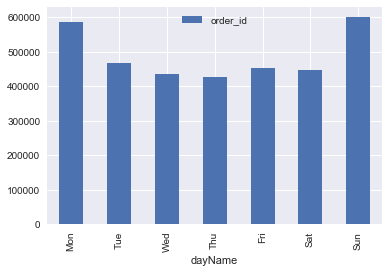

In [11]:
days = {0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'} #dictionary of numeric day:Alpha day
week = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun']

a = dfOrders #set new df equal to orders df
a['dayName']=a['order_dow'].apply(lambda x: days[x]) #create new column 'dayName' compare' order_dow' to dictionary
a = a.groupby(['dayName'])[['order_id']].count().reindex(week).plot.bar() #group the orders by dayName


# What time of day do people shop?
They are generally shopping in the early afternoon.

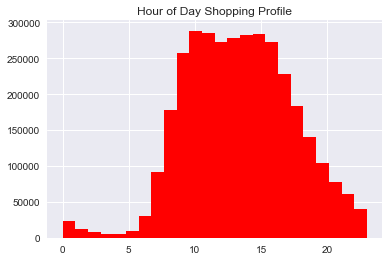

In [12]:
dfOrders['order_hour_of_day'].hist(bins=24,color='red')
plt.title("Hour of Day Shopping Profile")

In [13]:
dfOrders['order_hour_of_day'].describe()

count    3.421083e+06
mean     1.345202e+01
std      4.226088e+00
min      0.000000e+00
25%      1.000000e+01
50%      1.300000e+01
75%      1.600000e+01
max      2.300000e+01
Name: order_hour_of_day, dtype: float64

# How often are people shopping?
On average people place orders every 11 days.  There is an interesting spike towards the 30 day mark.  This may be worth investigating further.

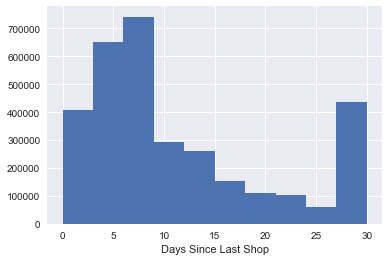

In [14]:
dfOrders['days_since_prior_order'].hist()
plt.xlabel("Days Since Last Shop")

In [15]:
dfOrders['days_since_prior_order'].describe()

count    3.214874e+06
mean     1.111484e+01
std      9.206737e+00
min      0.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.500000e+01
max      3.000000e+01
Name: days_since_prior_order, dtype: float64

# Which Department is the most popular for purchases?
Produce is where people shop the most.  The number of purchases outpaces snacks by a long way even though there are equivalent number of products in each department as we will see later.

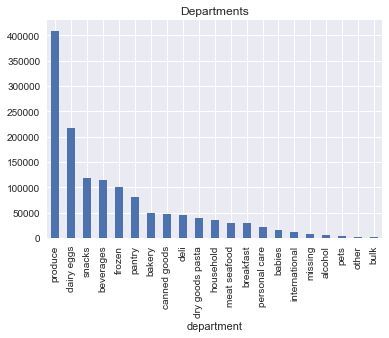

In [16]:
dfFun=dfOrdersTrain.merge(dfShelves) #combine the prior orders & shelf contents
a=dfFun.groupby(['department']).size().sort_values(ascending=False) #groupby department
a.plot(kind='bar',title='Departments')
#shows the most popular departments

# How are these sales reflected in each aisle?
I have developed a treemap in Tableau to illustrate the answer
<img src="files/DeptAislebySales.png">
People love to shop for:
 - Fresh Fruit and Veg
 - Chips and Pretzels
 - Sparkling Water
 - Ice Cream
 - Yogurt

# Which products do people buy most often?
The banana is the most popular product.

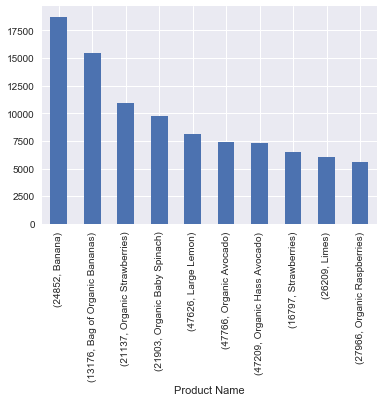

In [17]:
b=dfFun.groupby(['product_id','product_name']).size().sort_values(ascending=False)
b.head(10).plot.bar()
plt.xlabel("Product Name")

Another way of visualizing this is using a bubble chart made in Tableau
<img src="files/ProductbySalesBubble.png">

Alternatively a treemap could be used
<img src="files/ProductbySales.png">

# Which departments have the largest selection of products?
Personal care and snacks have the largest number of SKUs

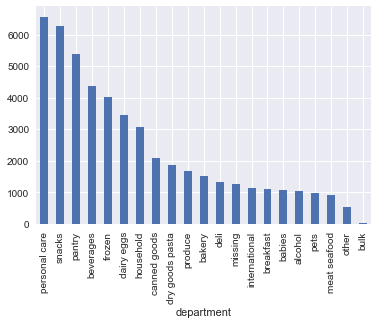

In [18]:
ProductVolume= dfShelves.groupby(['department']).size().sort_values(ascending=False)
ProductVolume.plot(kind='bar')

# Which products have the highest likelihood of being reordered?

I have produced a table and bar chart of the results.

The analysis was done by first calculating the mean of the products reordered data.  In order to clean out the small sample sizes I filtered out items that had purchases less than 40 times.


In [19]:
c=dfOrdersTrain.groupby(['product_id'],as_index=False)['reordered'].agg('mean')
c.rename(columns={'product_id':'product_id','reordered':'prop_reordered'},inplace=True)
my_list=dfOrdersTrain.groupby(['product_id'],as_index=False)['order_id'].count()
my_list.rename(columns={'product_id':'product_id','order_id':'order_count'},inplace=True)
d=c.merge(my_list,on='product_id')
r=d[(d['prop_reordered']!=1) & (d['order_count']>40)]
r=r.merge(dfProd,on='product_id')
r.sort_values(by='prop_reordered',ascending=False).head(10)

,product_id,prop_reordered,order_count,product_name,aisle_id,department_id
170,1729,0.934783,92,2% Lactose Free Milk,84,16
2237,20940,0.913043,368,Organic Low Fat Milk,84,16
1300,12193,0.898305,59,100% Florida Orange Juice,98,7
3401,31764,0.888889,45,Original Sparkling Seltzer Water Cans,115,7
2249,21038,0.888889,81,Organic Spelt Tortillas,128,3
2666,24852,0.884172,18726,Banana,24,4
13,117,0.883333,120,Petit Suisse Fruit,2,16
4256,39180,0.881988,483,Organic Lowfat 1% Milk,84,16
1326,12384,0.881041,269,Organic Lactose Free 1% Lowfat Milk,91,16
2594,24024,0.878525,461,1% Lowfat Milk,84,16


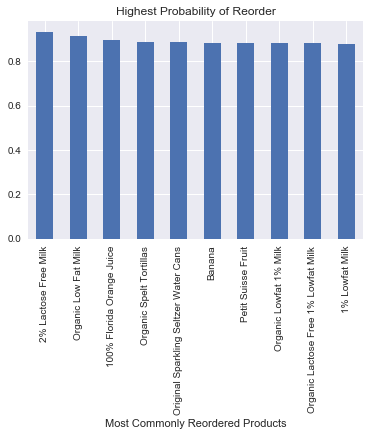

In [20]:
r.set_index('product_name')['prop_reordered'].sort_values(ascending=False).head(10).plot.bar(title='Highest Probability of Reorder')
plt.xlabel("Most Commonly Reordered Products")

The most reordered products are shown in the bar chart above.

# What relationship might exist between likelihood of reorder and days since prior order?

See the plot below, if the shopper purchases again within a week it is more likely a product will be reordered.

<img src="files/ReorderedbyDaysSince.png">

# How has the dataset been split up?
There are 3.4M prior orders in the dataset and they have been split up in to a training set, historical set and test set.

In [21]:
dfOrders.eval_set.value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

# How many Items do people usually buy?
The average purchase is 10 items

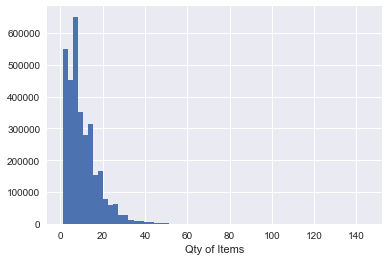

In [22]:
dfQtyBought = dfOrdersPrior.groupby(['order_id']).last()
dfQtyBought.reset_index()
dfQty = dfQtyBought['add_to_cart_order']
dfQty.plot.hist(bins=60)
plt.ylabel('')
plt.xlabel('Qty of Items')

In [23]:
dfQty.describe()

count    3.214874e+06
mean     1.008888e+01
std      7.525398e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: add_to_cart_order, dtype: float64

# Which items are most popular as a first selection?

We would expect the banana to be high on the list but spring water and soda also feature high on the list.

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


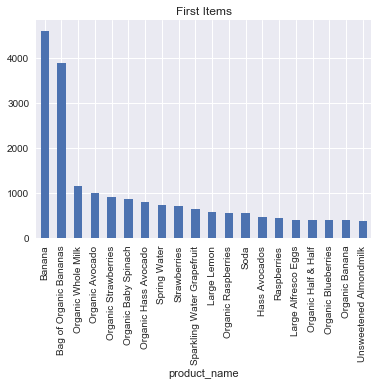

In [24]:
test = dfOrdersTrain.groupby(['add_to_cart_order','product_id'],as_index=False).count()
first_item=test.set_index('add_to_cart_order').sort_values(by=['order_id'],ascending=False)
ok=first_item.ix[1].head(20)
ok=ok.merge(dfProd,on='product_id')
ok.set_index('product_name')['order_id'].plot.bar(title='First Items')

# What's the craziest chart we can make with the data?
Here is a bubble chart of all products by their departments and relative sales...it makes for an orbital impression...I thought it was neat to look at more than anything.

<img src="files/ProductOrbits.png">

The data behind this story can be located at the following URL:
https://www.kaggle.com/c/instacart-market-basket-analysis

# Inferential Statistics

** average number of purchases per healthy order vs junkie order**
 - sample the produce aisle and the snacks aisle and compare the averages of days since last order
 
** correlation of proportion reordered and order count **

In [25]:
dfAvg = dfOrders.merge(dfOrdersPrior,on='order_id').merge(dfShelves,on='product_id')


In [26]:
# get dept = produce and dept = snacks
# compare the averages of days since prior order to see if people are eating their snacks faster!
dfHypoTest = dfAvg[(dfAvg['department_id']==19) | (dfAvg['department_id']==4)]


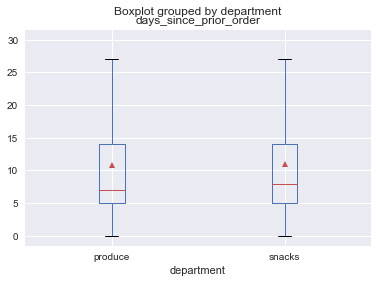

In [27]:
#dfHypoTest.groupby(['department_id'])['days_since_prior_order'].mean().plot.box(by='department_id')
ax1=dfHypoTest.boxplot(column='days_since_prior_order',by='department',showmeans=True)

In [28]:
def get_z(sample1, sample2):
    z = (np.mean(sample1) - np.mean(sample2)) / math.sqrt(np.std(sample1)**2/len(sample1)+np.std(sample2)**2/len(sample2))
    return z

In [29]:
dfHo = dfHypoTest[['department_id','days_since_prior_order']]
dfHo=dfHo.fillna(value=0)


In [30]:
produce = dfHo[dfHo['department_id']==4].as_matrix(columns=['days_since_prior_order'])
snacks = dfHo[dfHo['department_id']==19].as_matrix(columns=['days_since_prior_order'])
print(produce.mean(),snacks.mean())



10.1869432007 10.2619788402


In [31]:
# are these both normally distributed?
# can we compute a degrees of freedom for the t statistic?

In [32]:
z = get_z(produce,snacks)
print('Z statastic:', z)

Z statastic: -12.6960438308


 null hypothesis is that the means are equal and produce - snacks = 0
 alternative hypothesis is that the means aren't equal and produce - snacks < 0
 
99% confidence, reject the null hypothesis if z<= -zalpha

z alpha = -2.33

therefore we accept that produce mean days since prior order is less than snacks.

practically, people are buying produce more often and in greater quantities as confirmed by prior bar plot



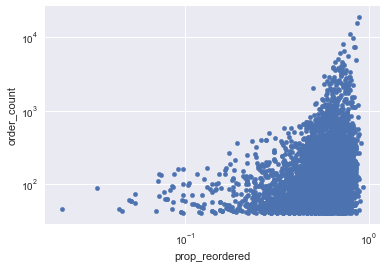

In [33]:
r.plot(x='prop_reordered',y='order_count',kind='scatter',loglog=True)

In [34]:
r.corr()

,product_id,prop_reordered,order_count,aisle_id,department_id
product_id,1.000000,-0.018973,0.019141,0.021470,-0.003057
prop_reordered,-0.018973,1.000000,0.173375,0.084448,0.005454
order_count,0.019141,0.173375,1.000000,-0.013277,-0.103093
aisle_id,0.021470,0.084448,-0.013277,1.000000,0.020069
department_id,-0.003057,0.005454,-0.103093,0.020069,1.000000


# Begin the Machine Learning Portion

In [35]:
c1=dfOrders[dfOrders['eval_set']=='train']
c2 = dfOrdersTrain.merge(dfShelves,on='product_id')
ProdCluster = c1.merge(c2,on='order_id')
#this uber matrix will allow us to cluster on anything regarding customer data in the training set after PCA

In [36]:
ProdCluster.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'dayName', 'product_id',
       'add_to_cart_order', 'reordered', 'product_name', 'aisle_id',
       'department_id', 'aisle', 'department'],
      dtype='object')

In [37]:
# create the pivot of the user id and qty purchases per aisle
clusterAisle = pd.crosstab(ProdCluster['user_id'],ProdCluster['aisle_id'])
clusterAisle.head(10)

aisle_id,1,2,3,4,5,6,7,8,9,10,...,125,126,127,128,129,130,131,132,133,134
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
14,0,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
clusterAisle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131209 entries, 1 to 206209
Columns: 134 entries, 1 to 134
dtypes: int64(134)
memory usage: 135.1 MB


# PCA Analysis

In [39]:
# begin the PCA
from sklearn.preprocessing import StandardScaler

In [40]:
scaler = StandardScaler()
scaler.fit(clusterAisle)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [41]:
scaled_data = scaler.transform(clusterAisle)

In [42]:
from sklearn.decomposition import PCA

In [43]:
pca = PCA(n_components=10)

In [44]:
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [45]:
x_pca = pca.transform(scaled_data)

In [46]:
scaled_data.shape

(131209, 134)

In [47]:
x_pca.shape

(131209, 10)

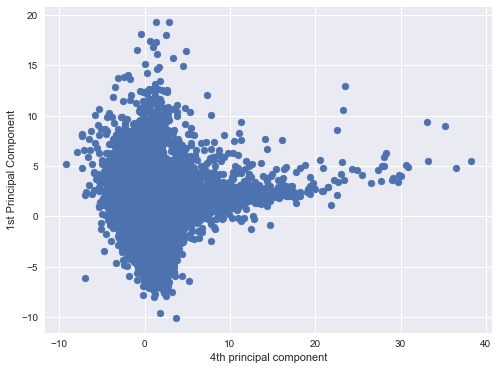

In [48]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,4],x_pca[:,1],cmap='plasma')
plt.xlabel('4th principal component')
plt.ylabel('1st Principal Component')

In [49]:
#dataframe of the pca components
dfx_pca=pd.DataFrame(x_pca)
dfx_pca.head(5)

,0,1,2,3,4,5,6,7,8,9
0,-0.205945,2.236661,-0.954978,-0.584295,0.333780,0.678128,-2.164628,-0.599935,0.103396,-0.150762
1,3.773227,3.013996,-1.658996,-1.525722,0.026627,2.079548,4.314400,-0.985567,2.734220,-0.339474
2,-0.260127,-0.315685,1.740972,-0.551992,0.413399,0.861541,-0.581533,1.049123,0.180881,0.098224
3,-0.680306,-0.309909,-0.295986,-0.682548,0.457136,0.165421,-0.455100,-0.028768,0.045614,-0.643724
4,1.203921,-4.088807,2.551277,-0.409595,0.784943,1.773880,0.707571,-0.497182,-1.316791,-0.284753


In [50]:
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios

,Explained Variance
0,0.0319
1,0.0181
2,0.0144
3,0.0126
4,0.0116
5,0.0108
6,0.0105
7,0.0096
8,0.0091
9,0.0090


In [51]:
# as a test we will pick the correlation of 1st and 4th components to use in clustering
tocluster = dfx_pca[[4,1]]

In [52]:
from sklearn.cluster import MiniBatchKMeans

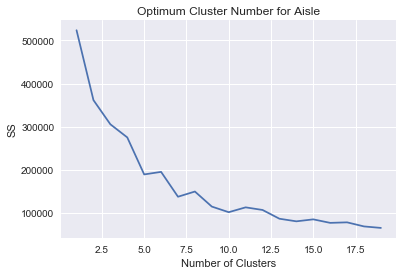

In [53]:
# implement elbow method to approximate cluster number
x =list(range(1,20))
y =[]
for k in range(1,20):
    kmeansAisle = MiniBatchKMeans(n_clusters = k)
    kmeansAisle.fit(tocluster)
    y.append(kmeansAisle.inertia_)
plt.plot(x,y)
plt.ylabel("SS")
plt.xlabel("Number of Clusters")
plt.title("Optimum Cluster Number for Aisle")

In [54]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = MiniBatchKMeans(n_clusters=6,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[ 0.3933201  -1.96664991]
 [-0.29931855  2.35092988]
 [ 0.13205967  0.10814301]
 [ 0.94872735  0.14728921]
 [ 5.03188943  1.54230694]
 [-0.6166506  -0.30450623]]


['blue', 'blue', 'purple', 'purple', 'orange', 'green', 'yellow', 'purple', 'green', 'purple']


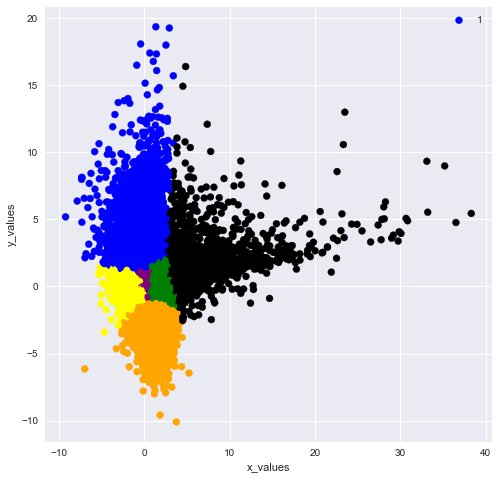

In [55]:
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green','black','yellow']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[4],tocluster[1],  color = colored)
#for ci,c in enumerate(centers):
#    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [56]:
clusterAisle['cluster'] = c_preds
clusterAisle.head(10)

aisle_id,1,2,3,4,5,6,7,8,9,10,...,126,127,128,129,130,131,132,133,134,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
8,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,5
13,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
14,0,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [57]:
clusterAisle.cluster.describe()

count    131209.000000
mean          2.608853
std           1.892373
min           0.000000
25%           1.000000
50%           2.000000
75%           5.000000
max           5.000000
Name: cluster, dtype: float64

In [58]:
# transform the PCA matrix to matrix of user_id x cluster indexed by aisle
c3=clusterAisle.reset_index()
dfUserbyCluster = c3[['user_id','cluster']]
dfUserbyCluster.head()

aisle_id,user_id,cluster
0,1,1
1,2,1
2,5,2
3,7,2
4,8,0


In [59]:
dfTrain = ProdCluster.merge(dfUserbyCluster,on='user_id')

In [60]:
r.columns

Index(['product_id', 'prop_reordered', 'order_count', 'product_name',
       'aisle_id', 'department_id'],
      dtype='object')

In [61]:
dfQuant=r[['product_id','prop_reordered','order_count']]

In [62]:
dfTrain.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'dayName', 'product_id',
       'add_to_cart_order', 'reordered', 'product_name', 'aisle_id',
       'department_id', 'aisle', 'department', 'cluster'],
      dtype='object')

# Try TruncatedSVD for PCA

In [63]:
from sklearn.decomposition import TruncatedSVD

In [64]:
clusterAisleSVD = clusterAisle.drop(['cluster'],axis=1)
clusterAisleSVD.head()

aisle_id,1,2,3,4,5,6,7,8,9,10,...,125,126,127,128,129,130,131,132,133,134
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [65]:
desired_explained_fraction =0.8
for n in range (22,26):
    tsvd = TruncatedSVD(n_components = n, n_iter = 100, tol=0.0001)
    tsvd.fit(clusterAisleSVD)
    ratio = np.sum(tsvd.explained_variance_ratio_)
    if (ratio > desired_explained_fraction):
        print((n,ratio))
        break
    else:
        print((n,ratio))
# 25 seems to be a reasonable size for dimensionality reduction of the Aisle matrix. now we can use this in clustering        

(22, 0.70596885084926098)
(23, 0.7146367518989003)
(24, 0.72313393758414268)
(25, 0.73133942943900521)


In [66]:
transformed_data = tsvd.transform(clusterAisleSVD)
dfTSVD = pd.DataFrame(transformed_data)
# here we transform the components in to a dataframe for further analysis

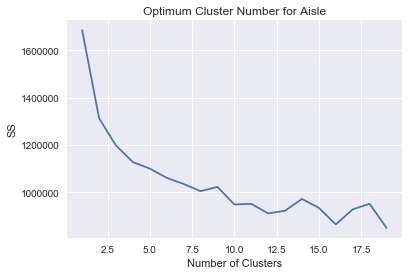

In [67]:
# implement elbow method to approximate cluster number
x =list(range(1,20))
y =[]
for k in range(1,20):
    kmeansAisle = MiniBatchKMeans(n_clusters = k)
    kmeansAisle.fit(dfTSVD)
    y.append(kmeansAisle.inertia_)
plt.plot(x,y)
plt.ylabel("SS")
plt.xlabel("Number of Clusters")
plt.title("Optimum Cluster Number for Aisle")

In [68]:
clustererTSVD = MiniBatchKMeans(n_clusters=5,random_state=42).fit(dfTSVD)
centersSVD = clustererTSVD.cluster_centers_
c_predsSVD = clustererTSVD.predict(dfTSVD)
print(centers)

[[ 0.3933201  -1.96664991]
 [-0.29931855  2.35092988]
 [ 0.13205967  0.10814301]
 [ 0.94872735  0.14728921]
 [ 5.03188943  1.54230694]
 [-0.6166506  -0.30450623]]


In [69]:
clusterAisleSVD['cluster'] = c_predsSVD
clusterAisleSVD.head(10)

aisle_id,1,2,3,4,5,6,7,8,9,10,...,126,127,128,129,130,131,132,133,134,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
8,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2
13,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
14,0,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [70]:
# transform the PCA matrix to matrix of user_id x cluster indexed by aisle
c4=clusterAisleSVD.reset_index()
dfUserbyClusterSVD = c4[['user_id','cluster']]
dfUserbyClusterSVD=dfUserbyClusterSVD.rename(columns={"user_id":"user_id","cluster":"cluster_svd"})
dfUserbyClusterSVD.head()

aisle_id,user_id,cluster_svd
0,1,2
1,2,3
2,5,2
3,7,2
4,8,1


In [71]:
dfTrainSVD = dfTrain.merge(dfUserbyClusterSVD,on='user_id')

In [72]:
dfTrainSVD = dfTrainSVD.merge(dfQuant,on='product_id')

In [73]:
dfTrainSVD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1129904 entries, 0 to 1129903
Data columns (total 20 columns):
order_id                  1129904 non-null int64
user_id                   1129904 non-null int64
eval_set                  1129904 non-null object
order_number              1129904 non-null int64
order_dow                 1129904 non-null int64
order_hour_of_day         1129904 non-null int64
days_since_prior_order    1129904 non-null float64
dayName                   1129904 non-null object
product_id                1129904 non-null int64
add_to_cart_order         1129904 non-null int64
reordered                 1129904 non-null int64
product_name              1129904 non-null object
aisle_id                  1129904 non-null int64
department_id             1129904 non-null int64
aisle                     1129904 non-null object
department                1129904 non-null object
cluster                   1129904 non-null int32
cluster_svd               1129904 non-null int3

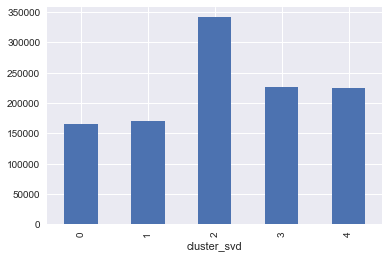

In [74]:
# try groupby SVD cluster and see which products are most purchased by barplots
dfTrainSVD.groupby(['cluster_svd']).size().plot.bar()

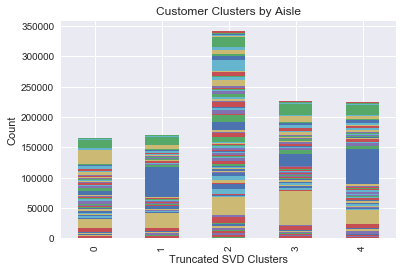

In [75]:
dfTrainSVD.groupby(['cluster_svd','aisle_id']).size().unstack('aisle_id').plot.bar(legend=False, stacked=True)
plt.title("Customer Clusters by Aisle")
plt.ylabel("Count")
plt.xlabel("Truncated SVD Clusters")

# Begin the Modelling
**Modelling to be done on predicting the reordered field**

In [101]:
dfTrainSVD_m = dfTrainSVD.drop(['eval_set','dayName','product_name','aisle','department', 'cluster','cluster_svd'],axis=1)
dfTrainSVD_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1129904 entries, 0 to 1129903
Data columns (total 13 columns):
order_id                  1129904 non-null int64
user_id                   1129904 non-null int64
order_number              1129904 non-null int64
order_dow                 1129904 non-null int64
order_hour_of_day         1129904 non-null int64
days_since_prior_order    1129904 non-null float64
product_id                1129904 non-null int64
add_to_cart_order         1129904 non-null int64
reordered                 1129904 non-null int64
aisle_id                  1129904 non-null int64
department_id             1129904 non-null int64
prop_reordered            1129904 non-null float64
order_count               1129904 non-null int64
dtypes: float64(2), int64(11)
memory usage: 160.7 MB


In [102]:
dfTrainSVD_m.corr()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id,prop_reordered,order_count
order_id,1.000000,-0.000282,0.002057,0.000994,-0.004170,0.002509,-0.000534,0.001883,0.001839,-0.000163,0.002871,-0.000434,0.000012
user_id,-0.000282,1.000000,-0.002566,-0.008051,-0.001009,0.002202,-0.000684,0.000210,-0.003369,0.000149,-0.001476,-0.000934,-0.000249
order_number,0.002057,-0.002566,1.000000,0.027109,-0.027757,-0.410430,-0.002844,0.017703,0.226531,-0.004229,-0.001466,0.050176,0.026493
order_dow,0.000994,-0.008051,0.027109,1.000000,0.006493,-0.027694,-0.004131,-0.017679,-0.005161,-0.002316,0.006072,-0.013255,-0.014801
order_hour_of_day,-0.004170,-0.001009,-0.027757,0.006493,1.000000,0.004876,0.001989,-0.009344,-0.018966,0.000350,-0.005130,-0.010028,-0.001043
days_since_prior_order,0.002509,0.002202,-0.410430,-0.027694,0.004876,1.000000,0.001298,0.015808,-0.165989,0.007684,0.007253,-0.028697,-0.022509
product_id,-0.000534,-0.000684,-0.002844,-0.004131,0.001989,0.001298,1.000000,0.005640,0.003486,-0.002402,-0.033525,0.012050,0.011020
add_to_cart_order,0.001883,0.000210,0.017703,-0.017679,-0.009344,0.015808,0.005640,1.000000,-0.147525,0.015006,0.022359,-0.161602,-0.099617
reordered,0.001839,-0.003369,0.226531,-0.005161,-0.018966,-0.165989,0.003486,-0.147525,1.000000,-0.005692,-0.038229,0.289283,0.142918
aisle_id,-0.000163,0.000149,-0.004229,-0.002316,0.000350,0.007684,-0.002402,0.015006,-0.005692,1.000000,0.072913,-0.019676,-0.250117


In [103]:
x = dfTrainSVD_m.drop(['reordered'],axis=1)
y = dfTrainSVD_m['reordered']

In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV

# Logistic Regression

In [105]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [106]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [107]:
predictions = logmodel.predict(X_test)

In [108]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00    138086
          1       0.63      1.00      0.77    234783

avg / total       0.40      0.63      0.49    372869



/Applications/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [109]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
results = model_selection.cross_val_score(logmodel, x, y, cv=kfold, scoring='neg_log_loss')
print(results.mean(), results.std())

-0.649719872148 0.0440360910538


In [110]:
confusion_matrix(y_test, predictions)

array([[     0, 138086],
       [     0, 234783]])

# Random Forest Classifier

In [111]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [112]:
rfc = RandomForestClassifier()

In [113]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [114]:
predictionsRF = rfc.predict(X_test)

In [115]:
print(classification_report(y_test,predictionsRF))

             precision    recall  f1-score   support

          0       0.55      0.55      0.55    125513
          1       0.74      0.74      0.74    213459

avg / total       0.67      0.67      0.67    338972



In [116]:
confusion_matrix(y_test, predictionsRF)

array([[ 69484,  56029],
       [ 56529, 156930]])

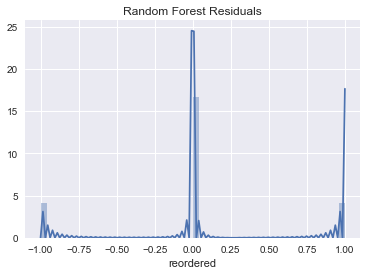

In [117]:
sns.distplot((y_test-predictionsRF),bins=50)
plt.title('Random Forest Residuals')

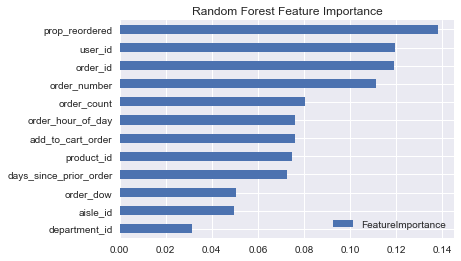

In [118]:
coefficientsRF = pd.DataFrame(rfc.feature_importances_,x.columns)
coefficientsRF.columns = ['FeatureImportance']
coefficientsRF=coefficientsRF.sort_values(by='FeatureImportance',ascending=True)
coefficientsRF.plot.barh()
plt.title('Random Forest Feature Importance')

# XGBoost Model

In [133]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [135]:
model = xgb.XGBClassifier(
 learning_rate = 0.1,
 n_estimators= 100,
 max_depth= 5,
 min_child_weight= 1,
 #gamma=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(X_train, y_train)

In [132]:
model.score(X_test,y_test)

0.70570135586420113

In [150]:
predictionsXGB = model.predict(X_test)

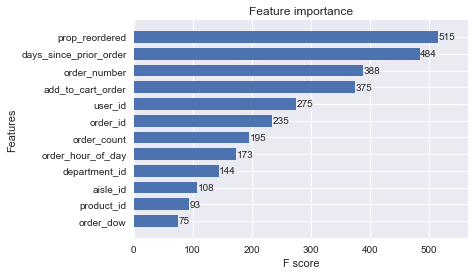

In [129]:
xgb.plot_importance(model, height=0.7)

In [151]:
print(classification_report(y_test,predictionsXGB))

             precision    recall  f1-score   support

          0       0.64      0.47      0.54    125513
          1       0.73      0.84      0.78    213459

avg / total       0.70      0.71      0.69    338972



In [152]:
confusion_matrix(y_test, predictionsXGB)

array([[ 59589,  65924],
       [ 33835, 179624]])

In [ ]:
# two questions
# how to apply k-folds, why do i need to do it if i have enough data for a typical train/test/split
# now that i have a model, how to test it on the competition test data? competition test dataset has no information on
# some of the fields in the training data

In [ ]:
# we can use cross validation in determining which model to use by way of 'hyper parameter tuning'
# randomizedSearchCV, GridSearchCV are examples

In [143]:
# use a full grid over all parameters
#param_grid = {"n_estimators": [25,50],
#              "max_depth": [5,10]                                   
#              }

In [153]:
# run random search
#random_search = GridSearchCV(model, param_grid=param_grid)
#random_search.fit(X_train,y_train)